In [1]:
import uproot3 as uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [4]:
## Import files with residuals
#run = 8552
#corr = 8461
#nolaser = "../output/residuals/Run_1/run8552_cosmics_timing_residuals_20230729_noLaser.csv"
#laser =  "../output/residuals/Run_1/run8552_cosmics_timing_residuals_20230729.csv"
#cosmics = "../output/residuals/Run_1/run8552_cosmics_timing_residuals_20230729_CORRw8461.csv"

#run = 9595
#corr = 9337
#laser = "../output/residuals/Run_2/run{}_residuals_test8ns.csv".format(run)
#cosmics = "../output/residuals/Run_2/run{}_residuals_test8ns_CORRw{}.csv".format(run,corr)

run = 11816
corr = 11813
nolaser = "output/Run_3/run{}_residuals_nocorr.csv".format(run)
laser =  "output/Run_3/run{}_residuals_laseronly.csv".format(run)
cosmics = "output/Run_3/run{}_residuals_lasercosmics.csv".format(run)

In [5]:
dfnolaser = pd.read_csv(nolaser).set_index(["channel_id"])
dflaser = pd.read_csv(laser).set_index(["channel_id"])
dfcosmics = pd.read_csv(cosmics).set_index(["channel_id"])

In [6]:
len(dfcosmics)
dfcosmics.head()

,x,y,z,entries,pecut,mean_residual_ns,std_residual_ns,emean_ns
channel_id,,,,,,,,
0,-371.07,-76.25,-872.90,39.0,300.0,-0.9071,1.5361,0.0394
1,-371.07,29.35,-872.90,32.0,300.0,-0.2557,1.4943,0.0467
2,-371.07,-129.05,-823.02,25.0,300.0,-0.0696,1.1973,0.0479
3,-371.07,-23.45,-823.02,71.0,300.0,-0.1417,1.6793,0.0237
4,-371.07,82.15,-823.02,99.0,300.0,-0.4009,1.5953,0.0161


## Comparison between before/after corrections

In [7]:
# The fit function
def gaus(x,a,mean,sigma):
    return a*np.exp(-(x-mean)**2/(2*sigma**2))

# The fit strategy
def fitGaussian(hdf, target='mean_residual_ns', BINSIZE=0.5,RMIN=-10.0,RMAX=10., p0=(0.1, 1.)):

    nbins=int((RMAX-RMIN)/BINSIZE)
    ys,edges = np.histogram(hdf[target],bins=nbins,range=(RMIN,RMAX))
    xs=np.array([edges[i]+0.5*(edges[i+1]-edges[i]) for i in range(len(ys))])

    param = [np.max(ys), p0[0], p0[1] ]
    bounds = np.array([(param[0]*0.5,param[0]*1.5),
              (param[1]*0.2,param[1]*1.3),
              (param[2]*0.1,param[2]*1.4)])
    
    param,pcov = curve_fit(gaus, xs, ys, p0=param, bounds=(bounds[:,0],bounds[:,1]) )
    param_errors = np.diag(pcov)**0.5
    
    return xs, ys, param, param_errors

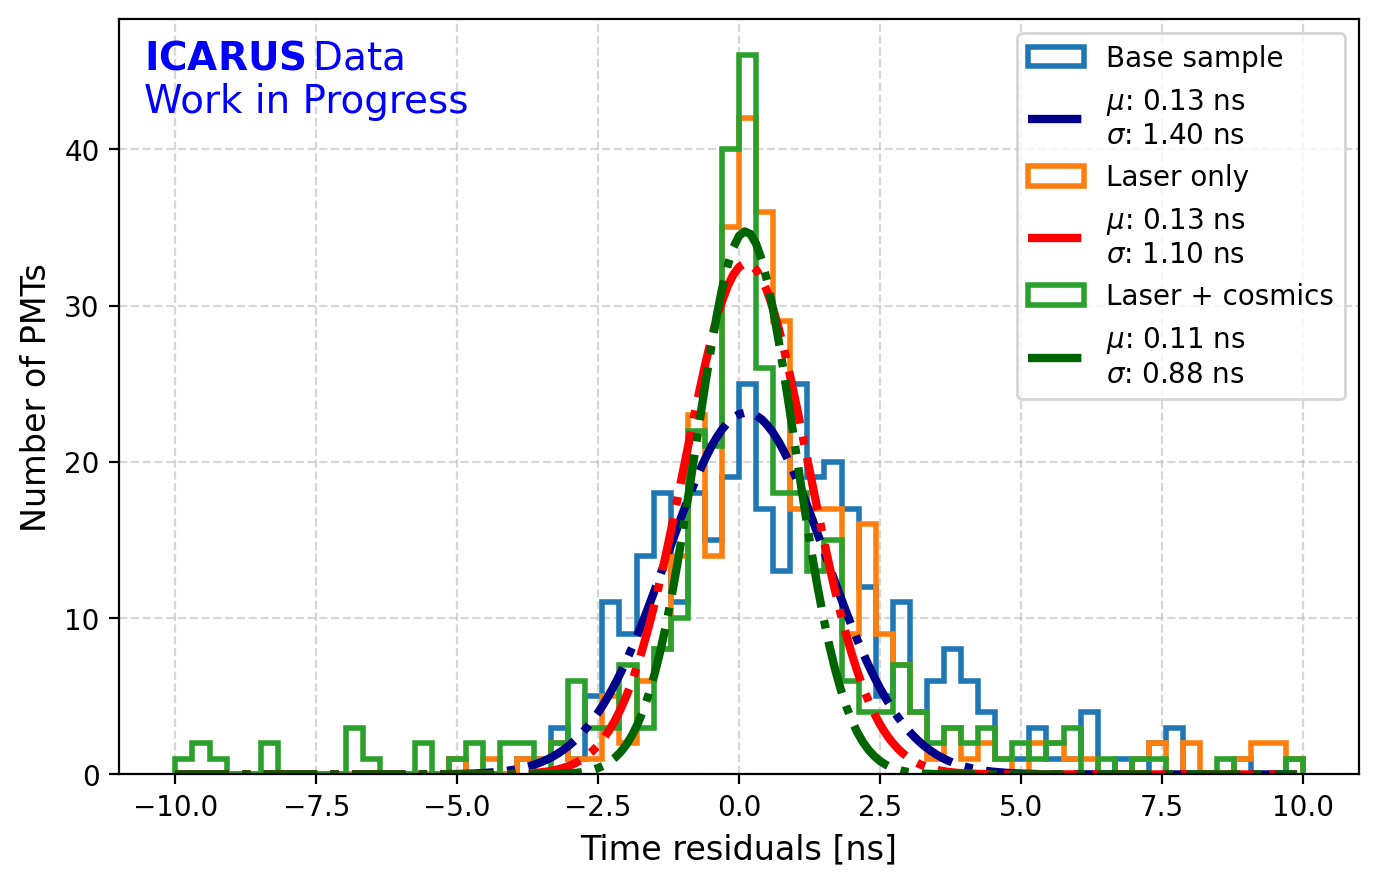

In [33]:
## Plotting residuals distribution with/without corrections
fig = plt.figure(figsize=(8,5),dpi=200)

rmin=-10
rmax=10
r=(rmin,rmax)
s=0.3
b=int((rmax-rmin)/s)

xs1, ys1, param1, param_errors1 = fitGaussian(dfnolaser,BINSIZE=s,RMIN=rmin,RMAX=rmax)
xs2, ys2, param2, param_errors2 = fitGaussian(dflaser,BINSIZE=s,RMIN=rmin,RMAX=rmax)
xs3, ys3, param3, param_errors3 = fitGaussian(dfcosmics,BINSIZE=s,RMIN=rmin,RMAX=rmax)
xss = np.arange(rmin,rmax,0.1)

### PLOT DISTRIBUTIONS
#l_nolaser = "Base sample\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(dfnolaser.mean_residual_ns),np.std(dfnolaser.mean_residual_ns))
#l_laser = "Laser only\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(dflaser.mean_residual_ns),np.std(dflaser.mean_residual_ns))
#l_cosmics = "Laser + cosmics\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(dfcosmics.mean_residual_ns),np.std(dfcosmics.mean_residual_ns))
#plt.hist(dfnolaser.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_nolaser)
#plt.hist(dflaser.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_laser)
#plt.hist(dfcosmics.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_cosmics)
#plt.legend()

### PLOT FITS
l_nolaser = "Base sample"
l_nolaserf= "$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param1[1],param1[2])
l_laser = "Laser only"
l_laserf = "$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param2[1],param2[2])
l_cosmics = "Laser + cosmics"
l_cosmicsf = "$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param3[1],param3[2])
plt.hist(dfnolaser.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_nolaser)
plt.plot(xss,gaus(xss,*param1),"-.",color="darkblue",lw=3, label=l_nolaserf)
plt.hist(dflaser.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_laser)
plt.plot(xss,gaus(xss,*param2),"-.",color="red",lw=3, label=l_laserf)
plt.hist(dfcosmics.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_cosmics)
plt.plot(xss,gaus(xss,*param3),"-.",color="darkgreen",lw=3, label=l_cosmicsf)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,4,1,5,2] ## for just 2
#order = [2,0,3,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

### PLOT SINGLE
#l_cosmics = "Gaussian fit\n$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param3[1],param3[2])
#plt.hist(dfcosmics.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step")
#plt.plot(xss,gaus(xss,*param3),"-.",color="red",lw=3,label=l_cosmics)
#plt.xlim((-5,5))
#plt.legend()

watermark = r'$\mathbf{ICARUS}\,$' + 'Data\nWork in Progress'
plt.text(0.02, 0.92, watermark, fontsize=14, color='blue', alpha=1,
         ha='left', va='center', transform=plt.gca().transAxes)

plt.xlabel("Time residuals [ns]",fontsize=12)
plt.ylabel("Number of PMTs",fontsize=12)
#plt.title("Run {} (including HW + laser + cosmics)".format(run))

plt.grid(linestyle="dashed",alpha=0.5)
name = "figs/run{}_base_vs_laseronly_vs_lasercosmics_w{}".format(run,corr)
plt.savefig(name+".pdf",dpi=200)
plt.show()

## Comparison between laser/cosmics residuals

In [31]:
#LASERCORR="/exp/icarus/data/users/mvicenzi/timing-database/pmt_laser_timing_data_run09628_from9772.csv"
#COSMICSCORR="output/residuals/Run_2/run{}_cosmics_timing_residuals.csv".format(corr)
#VOLTAGE="pmt_voltage_20221219.csv"

LASERCORR="/exp/icarus/data/users/mvicenzi/timing-database/pmt_laser_timing_data/pmt_laser_timing_data_run11590_from11641.csv"
COSMICSCORR="output/Run_3/run{}_residuals_laseronly.csv".format(corr)
VOLTAGE="pmt_voltage_20240212.csv"

lasercorr = pd.read_csv(LASERCORR, sep=r'\s*,\s*', engine='python')
lasercorr = lasercorr.rename(columns={'channel': 'channel_id'})
lasercorr.set_index(["channel_id"])
voltage = pd.read_csv(VOLTAGE).set_index(["channel_id"])
thisdfg = pd.read_csv(COSMICSCORR).set_index(["channel_id"])
thisdfg = thisdfg.join( lasercorr[["t_signal", "a", "b", "c"]], on="channel_id" ) 
thisdfg = thisdfg.join( voltage, on="channel_id" ) 
thisdfg["laser_res"] = thisdfg.apply( lambda x : x.t_signal-(x.a+x.b*np.power(x.voltage, x.c) ) , axis=1)

/tmp/ipykernel_833/2429394968.py:16: RuntimeWarning: divide by zero encountered in power
  thisdfg["laser_res"] = thisdfg.apply( lambda x : x.t_signal-(x.a+x.b*np.power(x.voltage, x.c) ) , axis=1)


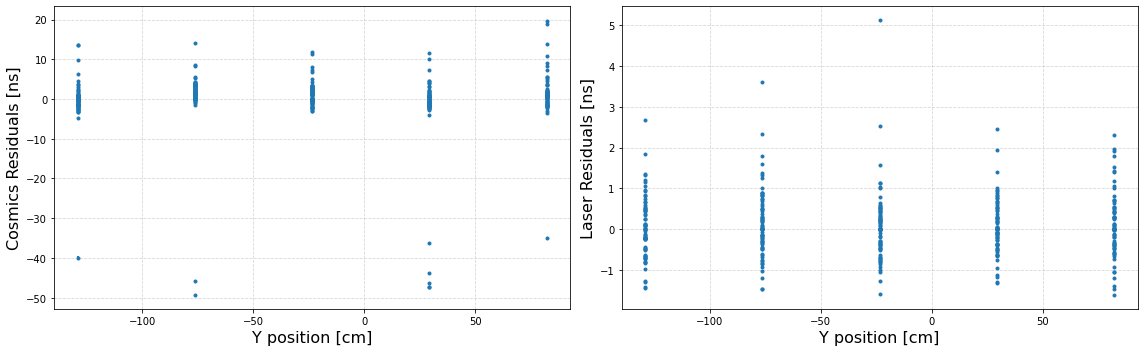

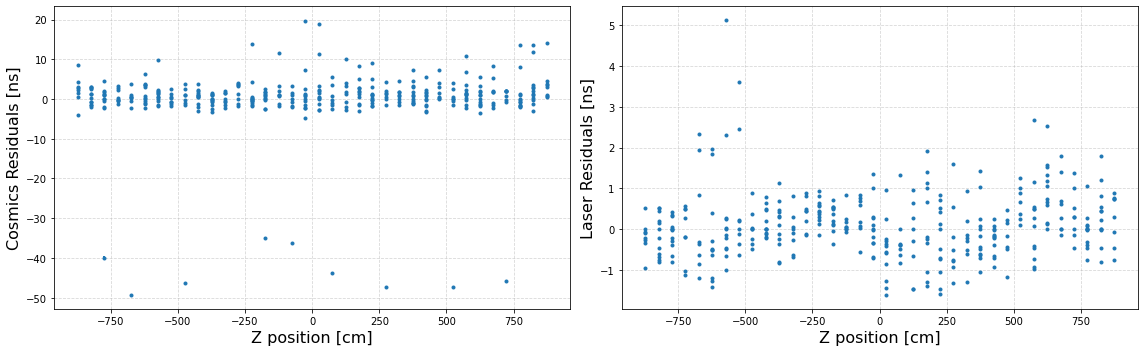

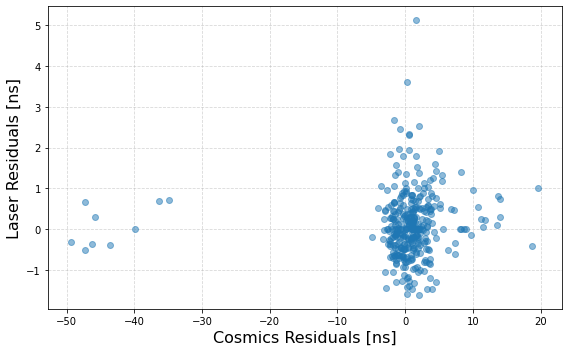

In [28]:
# Verify potential presence of biases 
fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax[0].errorbar( x=thisdfg.y, y=thisdfg.mean_residual_ns, yerr=thisdfg.emean_ns, marker='.', elinewidth=2.0, lw=0 )
ax[1].errorbar( x=thisdfg.y, y=thisdfg.laser_res, yerr=0, marker='.', elinewidth=2.0, lw=0 )
ax[1].set_ylabel("Laser Residuals [ns]", fontsize=16)
ax[0].set_ylabel("Cosmics Residuals [ns]", fontsize=16)
ax[1].set_xlabel("Y position [cm]", fontsize=16)
ax[0].set_xlabel("Y position [cm]", fontsize=16)
plt.tight_layout()
ax[0].grid(alpha=0.5,linestyle="dashed")
ax[1].grid(alpha=0.5,linestyle="dashed")
plt.savefig("figs/run{}_validation_laserVScomics_Y.png".format(corr),dpi=100)
plt.show()

fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax[0].errorbar( x=thisdfg.z, y=thisdfg.mean_residual_ns, yerr=thisdfg.emean_ns, marker='.', elinewidth=2.0, lw=0 )
ax[1].errorbar( x=thisdfg.z, y=thisdfg.laser_res, yerr=0, marker='.', elinewidth=2.0, lw=0 )
ax[1].set_ylabel("Laser Residuals [ns]", fontsize=16)
ax[0].set_ylabel("Cosmics Residuals [ns]", fontsize=16)
ax[1].set_xlabel("Z position [cm]", fontsize=16)
ax[0].set_xlabel("Z position [cm]", fontsize=16)
plt.tight_layout()
ax[0].grid(alpha=0.5,linestyle="dashed")
ax[1].grid(alpha=0.5,linestyle="dashed")
plt.savefig("figs/run{}_validation_laserVScomics_Z.png".format(corr),dpi=100)
plt.show()

# plot them togheter
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.errorbar( x=thisdfg.mean_residual_ns, y=thisdfg.laser_res, yerr=0, marker='o', elinewidth=2.0, lw=0, alpha=0.5 )
ax.set_ylabel("Laser Residuals [ns]", fontsize=16)
ax.set_xlabel("Cosmics Residuals [ns]", fontsize=16)

plt.tight_layout()
plt.grid(alpha=0.5,linestyle="dashed")
plt.savefig("figs/run{}_validation_laserVScomics_2Dscatter.png".format(corr),dpi=100)
plt.show()

In [29]:
thisdfg[thisdfg.mean_residual_ns<-10].head(12)

,x,y,z,entries,pecut,mean_residual_ns,std_residual_ns,emean_ns,t_signal,a,b,c,voltage,on,laser_res
channel_id,,,,,,,,,,,,,,,
5,-371.07,-129.05,-773.14,7.0,300.0,-39.9138,3.7216,0.5317,194.703,160.495,5698.26,-0.699481,1500.0,1.0,0.000072
21,-371.07,29.35,-473.86,1.0,300.0,-46.1880,0.0000,0.0000,194.339,160.495,5698.26,-0.699481,1500.0,1.0,-0.363928
59,-371.07,29.35,274.34,241.0,300.0,-47.2667,10.3123,0.0428,195.031,160.495,5698.26,-0.699481,1449.0,1.0,-0.509720
127,-49.36,82.15,-174.58,54.0,300.0,-34.8837,11.3584,0.2103,190.788,160.495,5698.26,-0.699481,1847.0,1.0,0.718955
131,-49.36,29.35,-74.82,178.0,300.0,-36.3228,17.7083,0.0995,194.933,160.495,5698.26,-0.699481,1529.0,1.0,0.685206
139,-49.36,29.35,74.82,171.0,300.0,-43.6578,11.4539,0.0670,189.084,160.495,5698.26,-0.699481,1902.0,1.0,-0.384223
161,-49.36,29.35,523.74,160.0,300.0,-47.3496,10.7037,0.0669,190.301,160.495,5698.26,-0.699481,1886.0,1.0,0.661065
190,49.36,-76.25,-673.38,410.0,300.0,-49.3170,6.0447,0.0147,189.364,160.495,5698.26,-0.699481,1883.0,1.0,-0.308406
350,371.07,-76.25,723.26,280.0,300.0,-45.7512,16.3883,0.0585,190.435,160.495,5698.26,-0.699481,1842.0,1.0,0.309826


In [30]:
thisdfg[thisdfg.mean_residual_ns>10].head(10)

,x,y,z,entries,pecut,mean_residual_ns,std_residual_ns,emean_ns,t_signal,a,b,c,voltage,on,laser_res
channel_id,,,,,,,,,,,,,,,
124,-49.36,82.15,-224.46,58.0,300.0,13.9478,10.6800,0.1841,195.109,160.495,5698.26,-0.699481,1494.0,1.0,0.310034
129,-49.36,29.35,-124.70,198.0,300.0,11.5092,9.0628,0.0458,192.047,160.495,5698.26,-0.699481,1688.0,1.0,0.055916
134,-49.36,82.15,-24.94,54.0,300.0,19.6654,9.5471,0.1768,197.751,160.495,5698.26,-0.699481,1381.0,1.0,1.011973
136,-49.36,-23.45,24.94,220.0,300.0,11.2351,7.1978,0.0327,194.612,160.495,5698.26,-0.699481,1521.0,1.0,0.240125
137,-49.36,82.15,24.94,39.0,300.0,18.8018,8.0240,0.2057,197.172,160.495,5698.26,-0.699481,1336.0,1.0,-0.416690
141,-49.36,29.35,124.70,230.0,300.0,10.0771,9.6525,0.0420,195.073,160.495,5698.26,-0.699481,1538.0,1.0,0.963484
164,-49.36,82.15,573.62,141.0,300.0,10.7792,8.5474,0.0606,196.430,160.495,5698.26,-0.699481,1429.0,1.0,0.546907
352,371.07,-129.05,773.14,153.0,300.0,13.5038,8.1526,0.0533,192.378,160.495,5698.26,-0.699481,1667.0,1.0,0.109905
355,371.07,-129.05,823.02,18.0,300.0,13.6647,4.9133,0.2730,199.235,160.495,5698.26,-0.699481,1294.0,1.0,0.808208


## Compare statistics

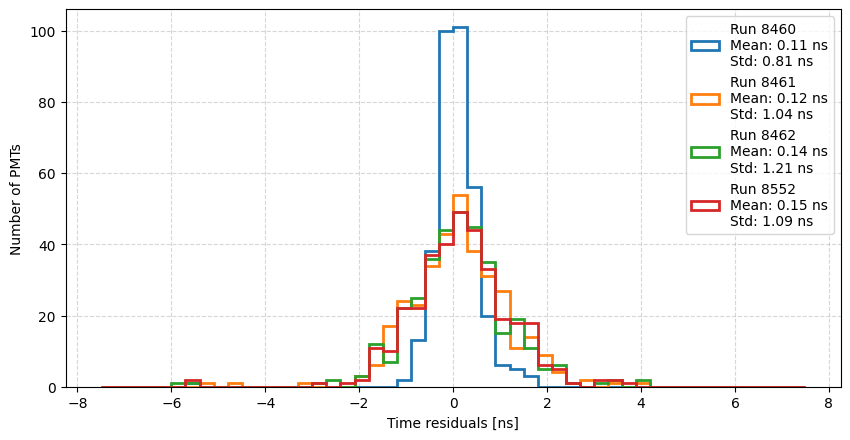

In [11]:
f1 = "../output/residuals/run8460_cosmics_timing_residuals_20230725.csv"
f2 = "../output/residuals/run8461_cosmics_timing_residuals_20230725.csv"
f3 = "../output/residuals/run8462_cosmics_timing_residuals_20230725.csv"
f4 = "../output/residuals/run8552_cosmics_timing_residuals_20230725.csv"

df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)
df3 = pd.read_csv(f3)
df4 = pd.read_csv(f4)

fig = plt.figure(figsize=(10,5),dpi=100)

l1 = "Run 8460\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df1.mean_residual_ns),np.std(df1.mean_residual_ns))
l2 = "Run 8461\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df2.mean_residual_ns),np.std(df2.mean_residual_ns))
l3 = "Run 8462\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df3.mean_residual_ns),np.std(df3.mean_residual_ns))
l4 = "Run 8552\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df4.mean_residual_ns),np.std(df4.mean_residual_ns))

plt.hist(df1.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l1)
plt.hist(df2.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l2)
plt.hist(df3.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l3)
plt.hist(df4.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l4)
plt.xlabel("Time residuals [ns]")
plt.ylabel("Number of PMTs")
plt.legend()
plt.grid(linestyle="dashed",alpha=0.5)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,5),dpi=100)

l1 = "Run 8460"
l2 = "Run 8461"
l3 = "Run 8462"
l4 = "Run 8552"
plt.hist(df1.entries, linewidth=2, histtype="step", label=l1)
plt.hist(df2.entries, linewidth=2, histtype="step", label=l2)
plt.hist(df3.entries, linewidth=2, histtype="step", label=l3)
plt.hist(df4.entries, linewidth=2, histtype="step", label=l4)
plt.xlabel("Entries per channel")
plt.ylabel("Number of PMTs")
plt.legend()
plt.grid(linestyle="dashed",alpha=0.5)
plt.show()

## Compare with different statistics

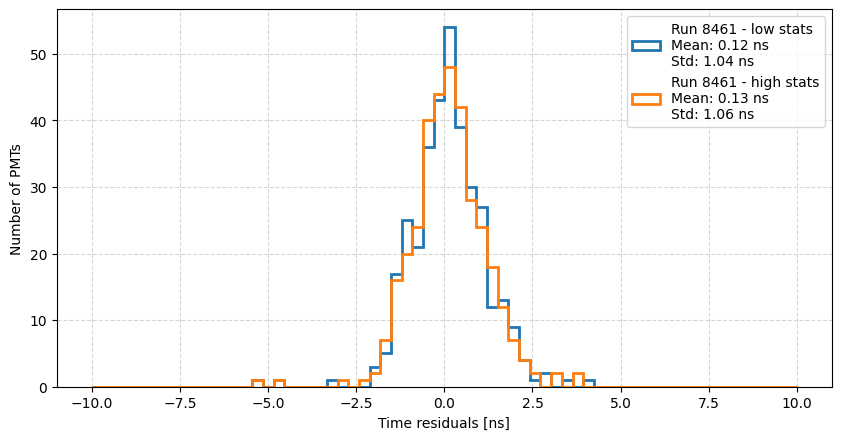

In [12]:
f1 = "../output/residuals/run8461_cosmics_timing_residuals_20230725.csv"
f2 = "../output/residuals/run8461_cosmics_timing_residuals_20230727.csv"

df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)

fig = plt.figure(figsize=(10,5),dpi=100)

l1 = "Run 8461 - low stats\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df1.mean_residual_ns),np.std(df1.mean_residual_ns))
l2 = "Run 8461 - high stats\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df2.mean_residual_ns),np.std(df2.mean_residual_ns))

plt.hist(df1.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l1)
plt.hist(df2.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l2)

plt.xlabel("Time residuals [ns]")
plt.ylabel("Number of PMTs")
plt.legend()
plt.grid(linestyle="dashed",alpha=0.5)
plt.show()

## Test old file cuts from Andrea

In [ ]:
f = "../output/run8413_matched_light_tracks_Andrea.txt"
df = pd.read_csv(f)
df.head()

In [ ]:
plt.hist( df.flashTime/1000 - df.trackTime/1000, histtype="step")
plt.show()

In [ ]:
plt.hist( df.flashLightZ - df.trackChargeZ, histtype = "step")
plt.show()

## Testing wrong corrections!

In [11]:
run = 9595
wrong = "../output/residuals/Run_2/run9595_residuals_TESTwrongCorr10085.csv"
correct = "../output/residuals/Run_2/run9595_residuals_test8ns_fixEast_alternative_CORRw9337.csv"
wrong2 = "../output/residuals/Run_2/run9595_residuals_TESTwrongCorr8461.csv"

In [12]:
dfwrong= pd.read_csv(wrong).set_index(["channel_id"])
dfcorrect = pd.read_csv(correct).set_index(["channel_id"])
dfwrong2= pd.read_csv(wrong2).set_index(["channel_id"])

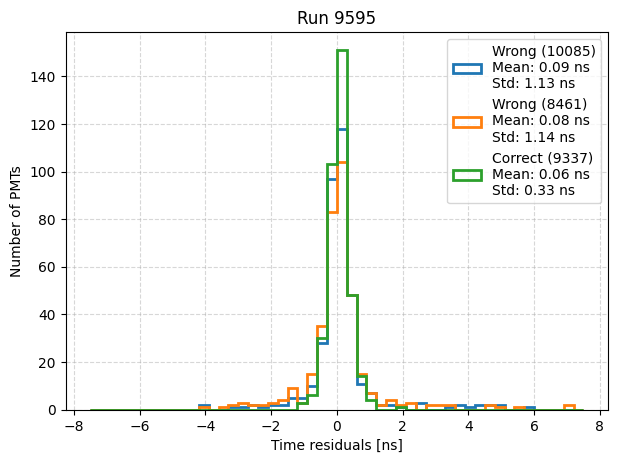

In [16]:
## Plotting residuals distribution with/without corrections
fig = plt.figure(figsize=(7,5),dpi=100)

rmin=-7.5
rmax=7.5
r=(rmin,rmax)
s=0.3
b=int((rmax-rmin)/s)

xs2, ys2, param2, param_errors2 = fitGaussian(dfwrong,BINSIZE=s,RMIN=rmin,RMAX=rmax)
xs3, ys3, param3, param_errors3 = fitGaussian(dfcorrect,BINSIZE=s,RMIN=rmin,RMAX=rmax)
xs4, ys4, param4, param_errors4 = fitGaussian(dfwrong2,BINSIZE=s,RMIN=rmin,RMAX=rmax)
xss = np.arange(rmin,rmax,0.1)

### PLOT FITS
l_correct = "Correct (9337)\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(dfcorrect.mean_residual_ns),np.std(dfcorrect.mean_residual_ns))
l_wrong = "Wrong (10085)\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(dfwrong.mean_residual_ns),np.std(dfwrong.mean_residual_ns))
l_wrong2 = "Wrong (8461)\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(dfwrong2.mean_residual_ns),np.std(dfwrong2.mean_residual_ns))

plt.hist(dfwrong.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_wrong)
plt.hist(dfwrong2.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_wrong2)
plt.hist(dfcorrect.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_correct)

plt.legend()

plt.xlabel("Time residuals [ns]")
plt.ylabel("Number of PMTs")
plt.title("Run {}".format(run))
plt.grid(linestyle="dashed",alpha=0.5)
plt.show()